<a href="https://colab.research.google.com/github/mlfa19/assignments/blob/master/Module%203/03/Exploring_COMPAS_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the ProPublica COMPAS Analysis

In this notebook you'll get a chance to examine the data used in the ProPublica story yourself.

*Disclaimer:*
Please don't over interpret what you find in the data.  We know from our discussions that methodology is key to being able to properly interpret findings.  Our goal here will be to reproduce results from the readings we did for last class.

First, we'll download and parse the data into a data frame.

In [2]:
import pandas as pd

!wget https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
df = pd.read_csv('compas-scores-two-years.csv')
df

--2019-10-24 03:07:49--  https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546489 (2.4M) [text/plain]
Saving to: ‘compas-scores-two-years.csv’

compas-scores-two-y 100%[===================>]   2.43M  --.-KB/s    in 0.09s   

2019-10-24 03:07:49 (26.4 MB/s) - ‘compas-scores-two-years.csv’ saved [2546489/2546489]



,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
5,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,0,1,0,0,0,0.0,2013-11-30 04:50:18,2013-12-01 12:28:56,13022355MM10A,2013-11-30,NaN,0.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-11-30,Risk of Violence,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,0,6,0,0,14,-1.0,2014-02-18 05:08:24,2014-02-24 12:18:30,14002304CF10A,2014-02-18,NaN,1.0,F,Possession Burglary Tools,1,14004485CF10A,(F2),0.0,2014-03-31,Poss of Firearm by Convic Felo,2014-03-31,2014-04-18,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,6,Medium,2014-02-19,Risk of Violence,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
7,9,steven stewart,steven,stewart,2013-08-30,Male,1973-02-25,43,25 - 45,Other,0,4,0,0,3,-1.0,2013-08-29 08:55:23,2013-08-30 08:42:13,13012216CF10A,NaN,2013-08-29,1.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-08-30,Risk of Violence,3,Low,2013-08-30,2014-05-22,2014-06-03,3,0,265,0,0
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,0,1,0,0,0,-1.0,2014-03-15 05:35:34,2014-03-18 04:28:46,14004524MM10A,2014-03-15,NaN,1.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2014-03-16,Risk of Violence,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
9,13,bo bradac,bo,bradac,2013-11-04,Male,1994-06-10,21,Less

In the ProPublica dataset they only used data where the "days_b_screening_arrest" feature was in the range [-30, 30].

In [0]:
# filter these based on propublica analysis (not sure why this doesn't match https://fairmlbook.org/classification.html)
df = df[(df['days_b_screening_arrest'] <= 30) | (df['days_b_screening_arrest'] >= -30)]

## Reproducing Calculations of False Positive Rate and Positive Predictive Value

From a statistical point of view (but not necessarily a social justice point of view) the debate between Propublica and NorthPointe boiled down to what is the rate way to measure bias in an algorithm.  As you saw in the first part of the assignmnet, ProPublica used the evidence that the false positive rate differed between blacks and whites as evidence of bias.  Northpointe argued used the fact that the positive predictive values across the two groups were the same as evidence *against* bias.

In Northpointe's report, they have a table which lists various statistics for blacks versus whites using the COMPAS risk scores as the predictor.  Here is the relevant information from their report.

|Race | $\hat{y} = 1$ | True positive rate | False Positive Rate | Positive Predictive Value | Negative Predictive Value
------|-----------------|---------------------|--------------------|------|------|
white | $decile \geq 1$ | 1.00 | 1.00 | 0.39 | 1.00 |
 | |$decile \geq 2$ | 0.85 | 0.64 | 0.46 | 0.79
 | |$decile \geq 3$ | 0.74 | 0.47 | 0.5 | 0.76
 | |$decile \geq 4$ | 0.64 | 0.35 | 0.54 | 0.74
 | |$decile \geq 5$ | 0.52 | 0.23 | 0.59 | 0.71
 | |$decile \geq 6$ | 0.41 | 0.15 | 0.64 | 0.69
 | |$decile \geq 7$ | 0.29 | 0.09 | 0.68 | 0.66
 | |$decile \geq 8$ | 0.20 | 0.05 | 0.71 | 0.65
 | |$decile \geq 9$ | 0.12 | 0.03 | 0.70 | 0.63
 | |$decile \geq 10$| 0.05 | 0.01 | 0.70 | 0.61
 | | | | |
 black | $decile \geq 1$ | 1.00 | 1.00 | 0.51 | 1.00 |
 | |$decile \geq 2$ | 0.95 | 0.83 | 0.55 | 0.77
 | |$decile \geq 3$ | 0.89 | 0.68 | 0.58 | 0.73
 | |$decile \geq 4$ | 0.81 | 0.56 | 0.60 | 0.69
 | |$decile \geq 5$ | 0.72 | 0.45 | 0.63 | 0.65
 | |$decile \geq 6$ | 0.63 | 0.34 | 0.66 | 0.62
 | |$decile \geq 7$ | 0.51 | 0.25 | 0.69 | 0.59
 | |$decile \geq 8$ | 0.39 | 0.16 | 0.72 | 0.57
 | |$decile \geq 9$ | 0.26 | 0.09 | 0.74 | 0.54
 | |$decile \geq 10$| 0.12 | 0.03 | 0.79 | 0.51

### *Notebook Exercise 1*

Write code to reproduce the table above.  Here are some hints to help you.

* If you're fuzzy on what each of these statistic means (false positive rate, true positive rate, etc.), consider checking out [Binary Diagnostic Tests](https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Binary_Diagnostic_Tests-Single_Sample.pdf).
* You'll want to use the column `df['two_year_recid']` as your indicator of true positive versus true negative (positive means that the person recidivated).
* To select narrow the data frame to just contain people of a particular race you can use the following snippet (`race` would be a string that is either "Caucasian" or "African-American").
```python
df_for_race = df[df['race'] == race]
```
* To generate a particular row of the table, you'll want to loop over all possible thresholds where the model would predict recidivate ($\hat{y} = 1$).
* You can count the number of elements in a Pandas series that satisfy some criterion using the following technique.  For instance, if we wanted to calculate the number of elements in "some_column" that are greater than 0 and less than 30, we could use the following code.
```python
((df['some column'] > 0).sum() & (df['some column'] < 30).sum()
```
* It's up to you how you want to generate the table.  You can simply print out the values within a loop as you compute them, or you could populate a data frame with your calculations and then plot them (this is what we did in the solution).


#### *Expand for Solution*

In [23]:
# ***Solution***

# we're going to create a data frame to hold all of the results.  Think of this
# as a represntation of the 
results = pd.DataFrame(columns=['race', 'decile >=', 'true_positive_rate', 'false_positive_rate', 'positive_predictive_value', 'negative_predictive_value'])

for race in ['Caucasian', 'African-American']:
    df_for_race = df[df['race'] == race]
    y = df_for_race['two_year_recid']
    for thresh in range(1, 11):
        yhat = df_for_race['decile_score'] >= thresh
        true_positive_rate = ((y == 1) & (yhat == 1)).sum() / (y == 1).sum()
        false_positive_rate = ((y == 0) & (yhat == 1)).sum() / (y == 0).sum()
        if (yhat == 1).sum() == 0:
            positive_predictive_value = float('nan')
        else:
            positive_predictive_value = ((y == 1) & (yhat == 1)).sum() / (yhat == 1).sum()

        if (yhat == 0).sum() == 1:
            negative_predictive_value = float('nan')
        else:
            negative_predictive_value = ((y == 0) & (yhat == 0)).sum() / (yhat == 0).sum()

        results = results.append({'race': race,
                                  'decile >=': str(thresh),
                                  'true_positive_rate': true_positive_rate,
                                  'false_positive_rate': false_positive_rate,
                                  'positive_predictive_value': positive_predictive_value,
                                  'negative_predictive_value': negative_predictive_value}, ignore_index=True)
results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


,race,decile >=,true_positive_rate,false_positive_rate,positive_predictive_value,negative_predictive_value
0,Caucasian,1,1.000000,1.000000,0.402439,NaN
1,Caucasian,2,0.852665,0.638987,0.473318,0.784404
2,Caucasian,3,0.736677,0.469388,0.513848,0.749503
3,Caucasian,4,0.642633,0.348346,0.554054,0.730284
4,Caucasian,5,0.526646,0.231527,0.605042,0.706796
5,Caucasian,6,0.410658,0.144265,0.657191,0.683146
6,Caucasian,7,0.294671,0.090077,0.687805,0.657012
7,Caucasian,8,0.203762,0.052780,0.722222,0.638520
8,Caucasian,9,0.118077,0.032372,0.710692,0.619648
9,Caucasian,10,0.047022,0.013371,0.703125,0.605877


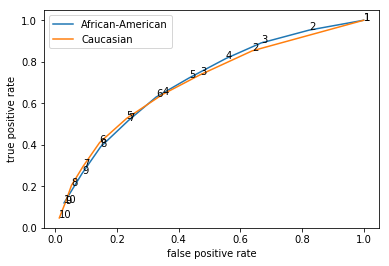

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
legend_strings = []
for race, df_by_race in results.groupby('race'):
    plt.plot(df_by_race['false_positive_rate'], df_by_race['true_positive_rate'])
    for _, row in df_by_race.iterrows():
        ax.annotate(str(row[1]), (row[3], row[2]))
    legend_strings.append(race)

plt.legend(legend_strings)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

Notice how for a given threshold (annotated as text), the curves have vastly different false positive rates.

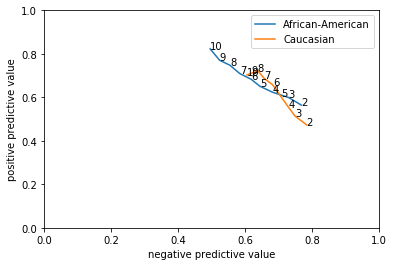

In [26]:
fig, ax = plt.subplots()
legend_strings = []
for race, df_by_race in results.groupby('race'):
    plt.plot(df_by_race['negative_predictive_value'], df_by_race['positive_predictive_value'])
    for _, row in df_by_race.iterrows():
        ax.annotate(str(row[1]), (row[5], row[4]))
    legend_strings.append(race)

plt.legend(legend_strings)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('negative predictive value')
plt.ylabel('positive predictive value')
plt.show()

Notice how for a threshold of 4 or 5, the positive predictive values are almost identical.

## Sanity Check Using Sklearn

We can compare our calculations to the ROC curve (false positive rate versus true postive rate).

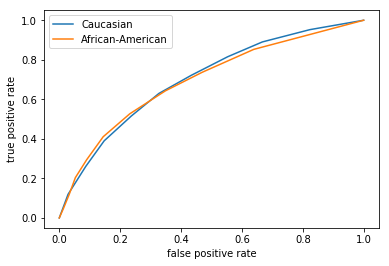

In [7]:
from sklearn import metrics

for race in ['African-American', 'Caucasian']:
    df_filtered = df[df['race'] == race]
    y = df_filtered['two_year_recid']
    scores = df_filtered['decile_score']
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
    plt.plot(fpr, tpr)
plt.legend(['Caucasian', 'African-American'])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()